In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

# Visualizing Masked Self-Attention


In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import os

from src.layers.attention import scaled_dot_product_attention
from presentation.pipelines.steps.load_data import build_loader
from presentation.pipelines.steps.model_design import load_pt_model
from src.models.astromer_0 import positional_encoding


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2024-09-16 17:59:04.998772: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 17:59:04.998821: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 17:59:04.998853: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 17:59:05.008195: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [45]:
model_path = './presentation/results/mask-alpha/2024-09-04_11-40-14/pretraining/'
astromer, config = load_pt_model(model_path)

loaders = build_loader('./data/shared/records/snr_macho/100/fold_0/', 
                       params=config,
                       batch_size=5, 
                       sampling=True,
                       probed=0.)

[INFO] Loading BASE
[INFO] Temperature: 0.00
[INFO] Mask format: K
[INFO] Probed: 0.00 Random: 0.20 Same: 0.20
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows
[INFO] Probed: 0.00 Random: 0.20 Same: 0.20
[INFO] Normalization:  zero-mean
[INFO] Sampling random windows


In [46]:
encoder = astromer.get_layer('encoder')

for batch, _ in loaders['train'].take(1):
    if config['arch'] == 'base':
        x, _ = encoder.input_format(batch)
        x = encoder.dropout_layer(x, training=False)

    if config['arch'] == 'zero':
        x_pe = positional_encoding(batch['times'], config['num_heads']*config['head_dim'], mjd=True)
        x_transformed = encoder.inp_transform(batch['input'])
        transformed_input = x_transformed + x_pe
        x = encoder.dropout(transformed_input, training=False)

    Q = encoder.enc_layers[-1].mha.wq(x)
    Q = encoder.enc_layers[-1].mha.split_heads(Q, batch_size=5)

    K = encoder.enc_layers[-1].mha.wk(x)
    K = encoder.enc_layers[-1].mha.split_heads(K, batch_size=5)

    V = encoder.enc_layers[-1].mha.wv(x)
    V = encoder.enc_layers[-1].mha.split_heads(V, batch_size=5)

    mask = batch['mask_in']

### Effect of temperature

In [47]:
w = []
temps = np.arange(0.5, 2.1, 0.5)
for t in temps:
    scaled_attention, attention_weights, qk_values = scaled_dot_product_attention(Q, 
                                                                                  K, 
                                                                                  V, 
                                                                                  mask=tf.zeros_like(mask), 
                                                                                  m_alpha=-1e9, 
                                                                                  mask_format='K',
                                                                                  temperature=t)
    
    w.append(attention_weights)

In [48]:
master = w[-1][0, 0, :, 0]

attention_vectors = []
for ww in w:
    master = ww[0, 0, 10, :]
    attention_vectors.append(master)

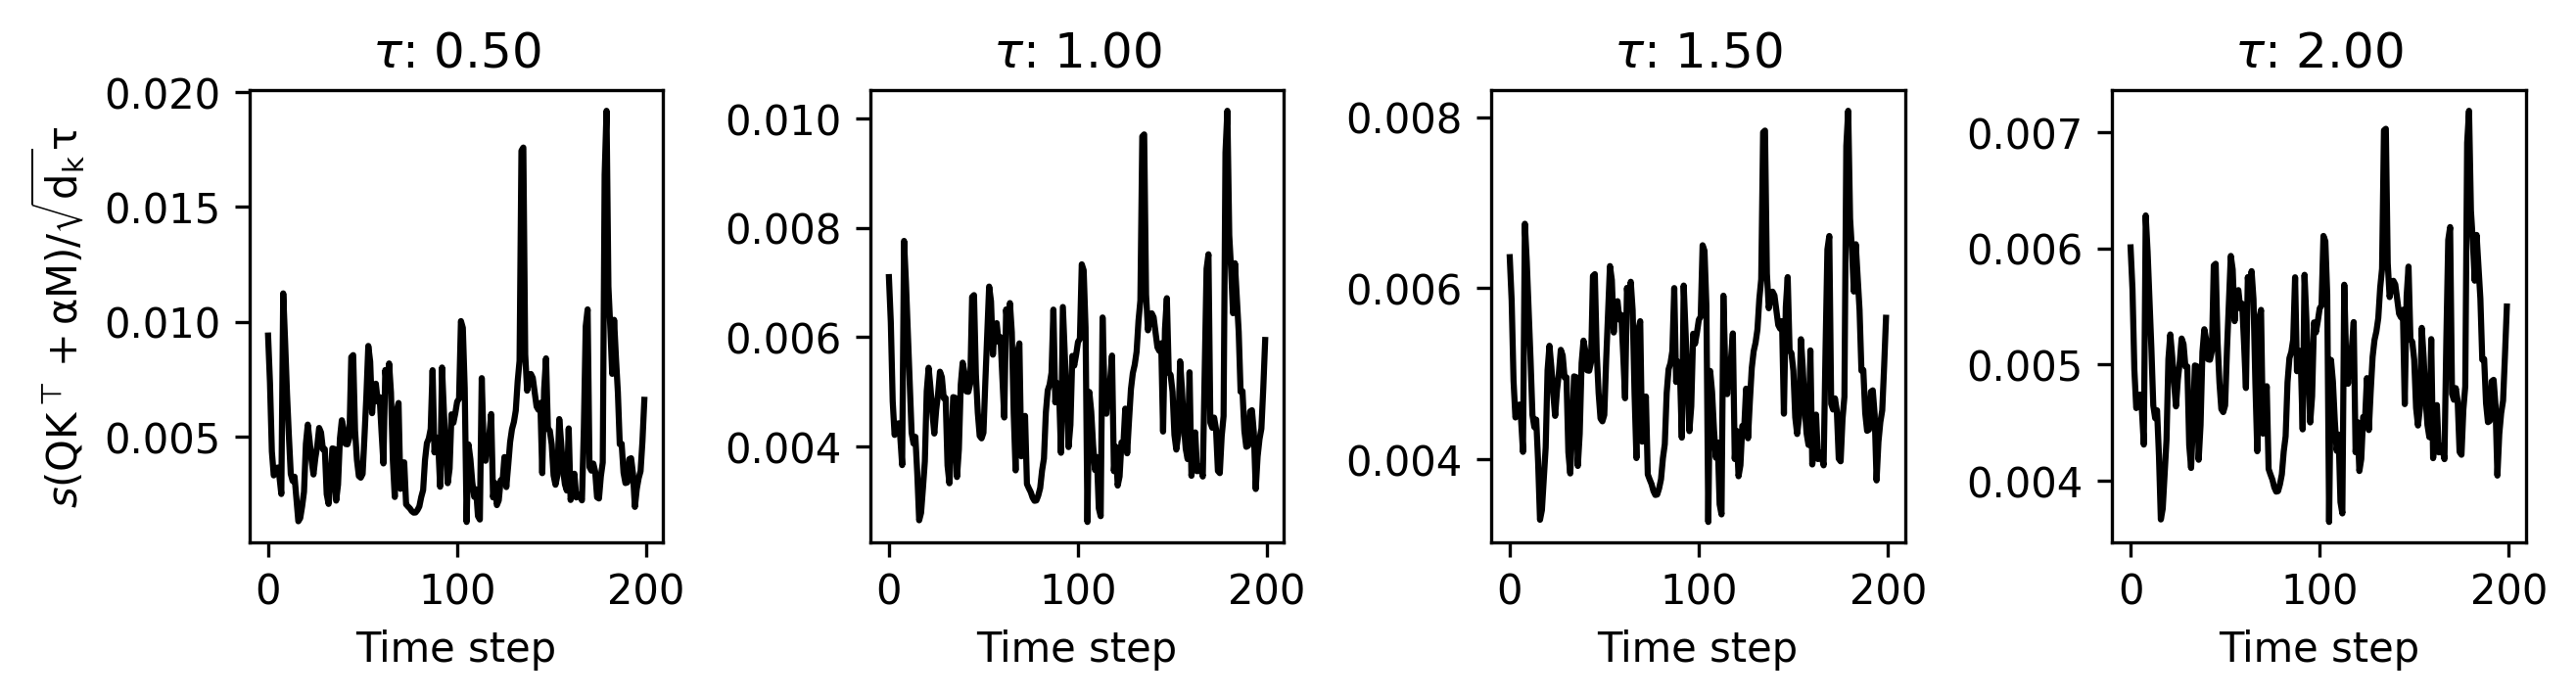

In [49]:
fig, axes = plt.subplots(1, 4, figsize=(10,2.), sharey=False, dpi=300, gridspec_kw={'wspace':0.5})

for index, av in enumerate(attention_vectors):
    axes[index].plot(av, color='k')
    axes[index].set_title(r'$\tau$: {:.2f}'.format(temps[index]))
    axes[index].set_xlabel('Time step')
    # axes[index].set_yscale('log')
    
axes[0].set_ylabel(r'$s(\rm{QK}^{\top} +\alpha\rm{M})/\sqrt{d_k}\tau$')
fig.savefig('./presentation/figures/temperature.pdf', format='pdf', bbox_inches='tight')

### Effect of alpha when masking via softmax arg

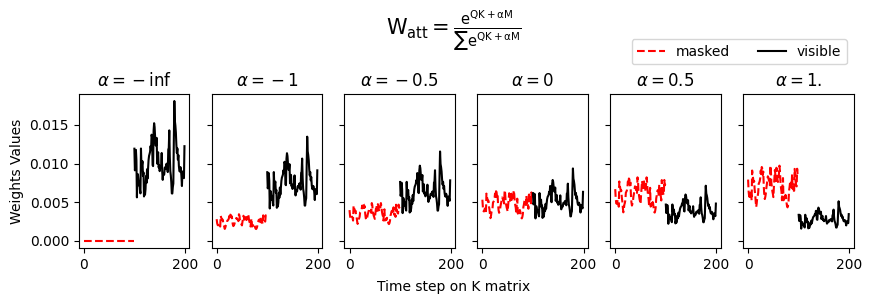

In [50]:
alphas = [-1e9, -1, -0.5, 0, 0.5, 1]
labels = [r'$\alpha=-\inf$', r'$\alpha=-1$', r'$\alpha=-0.5$', r'$\alpha=0$', r'$\alpha=0.5$', 
          r'$\alpha=1.$']

fig, axes = plt.subplots(1, 6, figsize=(10, 2), dpi=100, sharey=True)
axes = axes.flatten()
sim_matrices = []
for i, alp in enumerate(alphas):
    mask_dim = mask.shape
    neg = tf.ones([mask_dim[0], mask_dim[1]//2, mask_dim[2]])
    pos = tf.zeros([mask_dim[0], mask_dim[1]//2, mask_dim[2]])
    mask_new = tf.concat([neg, pos], 1)
    
    scaled_attention, attention_weights, qk_values = scaled_dot_product_attention(Q, K, V, mask=mask_new, m_alpha=alp, mask_format='K')


    v = attention_weights[0, 0, 0]

    axes[i].plot(range(0, 100), v[:100], label='masked', color='red', linestyle='--')
    axes[i].plot(range(100, 200), v[100:200], label='visible', color='k')
    axes[i].set_title('{}'.format(labels[i]))
    # axes[i].set_yscale('log')
    # axes[i].set_xlabel('Time Step on K')
    sim_matrices.append(attention_weights[0, 0])

axes[-1].legend(bbox_to_anchor=(1., 1.4), ncols=2)
axes[0].set_ylabel('Weights Values')
fig.text(0.5,1.3,r'$\rm{W}_{att} = \frac{e^{QK + \alpha M}}{\sum e^{QK+ \alpha M}}$',horizontalalignment='center',
       verticalalignment='top', fontsize=15)
fig.text(0.5,-0.05,'Time step on K matrix',horizontalalignment='center',
       verticalalignment='top', fontsize=10)
fig.savefig('./presentation/figures/alpha_on_weights.pdf', format='pdf', bbox_inches='tight')


Text(0, 0.5, 'Time Step on Q')

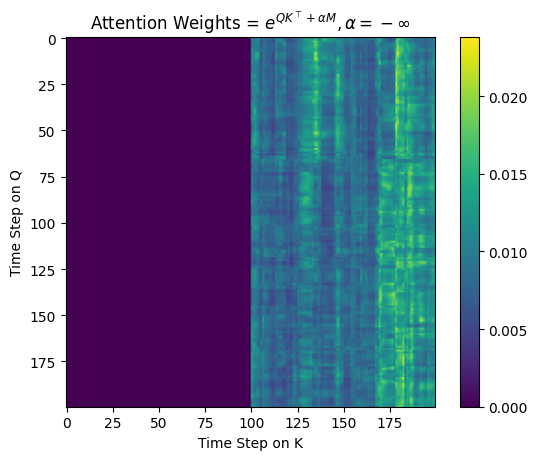

In [51]:
plt.figure(dpi=100)
plt.imshow(sim_matrices[0])
plt.title(r'Attention Weights = $e^{QK^{\top} + \alpha M}, \alpha = -\infty$')
plt.colorbar()
plt.xlabel('Time Step on K')
plt.ylabel('Time Step on Q')